<a href="https://colab.research.google.com/github/lonestarchaser/SED/blob/main/Automate_Catalog_Search_with_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Read a Table into IRSA Catalog Search Tool, Make a Match, and Make a Plot

Find the gj.tbl file. This is the Gliese-Jareiss catalog of nearby stars. All of them should be pretty good coordinates; the positions come from https://ui.adsabs.harvard.edu/abs/2010PASP..122..885S/abstract

This is our goal, but to do it in Python:

* Go to IRSA Catalog Search Tool
* Pick Gaia DR3
* Do a multi-object search
  * 1-to-1 matching
  * 2 arcsecond radius
* Upload the gj.tbl list of sources

Some acronyms you might like to know:
* ADQL = Astronomical Data Query Language
* TAP = Table Access Protocol


## First, install Astropy libraries and import packages and subpackages
These aren't normally included in Colab. You can save yourself some time and only have to run this once per time you open this.

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery gala

## Import subpackages


In [ ]:

from google.colab import drive
import numpy as np

import requests

import pandas as pd

import matplotlib.pyplot as plt

## Connect to your Google Drive

In order to read the file that you have saved on Google Drive, you need to mount you Google Drive to this Google Colab notebook. This will allow you to access your Google Drive files directly from your notebook.

It's going to ask for a lot of permissions.  Just get over it.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now you can list the files in that directory.  I put in ``\Colab Notebooks`` because that's where I saved the ``gj.tbl`` file.

You can do this to confirm the file is actually there:

``!ls "/content/drive/My Drive/Colab Notebooks" ``

# Connect to the TAP Server and run a query

I took the code from here:  https://irsa.ipac.caltech.edu/docs/program_interface/TAP.html

Then, in an act of desperation, I got ChatGPT to fix it for me.

I just said, "convert this into something I can use in google colab in python:"

`` curl -o fp_psc.tbl -F "UPLOAD=my_table,param:table.tbl" -F "table.tbl=@upload.tbl" -F "FORMAT=IPAC_TABLE" -F "QUERY=SELECT fp_psc.ra, fp_psc.dec FROM fp_psc WHERE CONTAINS(POINT(ra,dec), CIRCLE(TAP_UPLOAD.my_table.my_ra, TAP_UPLOAD.my_table.my_dec, 0.01)) =1" https://irsa.ipac.caltech.edu/TAP/sync ``

Now this one in particular is running a query against the 2MASS catalog (formatting it as code so you don't have to run it, but you can always run it for funzies/to test).


```
url = 'https://irsa.ipac.caltech.edu/TAP/sync'
query = (
    "SELECT fp_psc.ra, fp_psc.dec "
    "FROM fp_psc "
    "WHERE CONTAINS(POINT(ra,dec), CIRCLE(TAP_UPLOAD.my_table.ra, TAP_UPLOAD.my_table.dec, 2.0/3600.)) = 1"
)

files = {
    'UPLOAD': 'my_table,param:table.tbl',
    'table.tbl': open("/content/drive/My Drive/Colab Notebooks/gj.tbl", 'rb')
}

funData = {
    'FORMAT': 'IPAC_TABLE',
    'QUERY': query
}

response = requests.post(url, files=files, data=funData)
if response.status_code == 200:
    response_content = response.content
    with open("/content/drive/My Drive/Colab Notebooks/fun_fp_psc_output.tbl", 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print(f"Error: {response.status_code}")

print(response_content)
```

## So let's adjust that code and make it work with Gaia!

Go to this website:
https://www.ipac.caltech.edu/dois/irsa

Click on the database you want...

And then in the hyperlink on the next page you can see what the catalog is called.

https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd?catalog=gaia_edr3_source

So I'll use ``gaia_edr3_source``

....... Except now in the update it looks like they're hiding that information....

Fun fact:

IRSA says there should be 654 non-null entries, but it's only doing the closest match.  Here, I'm getting potentially multiple matches per item, so I get 699.

To do math later we need just these columns:
* ra: Right ascension
* dec: Declination
* parallax: Parallax
* phot_g_mean_mag: G-band mean magnitude
* bp_rp: BP - RP color
* phot_bp_mean_mag: Integrated BP mean magnitude
* phot_rp_mean_mag: Integrated RP mean magnitude


In [ ]:
url = 'https://irsa.ipac.caltech.edu/TAP/sync'
query = (
    "SELECT TAP_UPLOAD.my_table.name, g.ra, g.dec, g.parallax, g.phot_g_mean_mag, g.bp_rp, g.phot_bp_mean_mag, g.phot_rp_mean_mag "
    "FROM gaia_edr3_source AS g "
    "WHERE CONTAINS(POINT(ra,dec), CIRCLE(TAP_UPLOAD.my_table.ra, TAP_UPLOAD.my_table.dec, 2.0/3600.0)) = 1"
)

files = {
    'UPLOAD': 'my_table,param:table.tbl',
    'table.tbl': open("/content/drive/My Drive/Colab Notebooks/gj.tbl", 'rb')
}

funData = {
    'FORMAT': 'IPAC_TABLE',
    'QUERY': query
}

response = requests.post(url, files=files, data=funData)
if response.status_code == 200:
    response_content = response.content

    with open("/content/drive/My Drive/Colab Notebooks/funGaiaOutput.tbl", 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print(f"Error: {response.status_code}")

print(response_content)

File downloaded successfully.
b"\\fixlen = T\n\\RowsRetrieved = 699\n\\QUERY_STATUS = 'OK'\n\\ name\n\\ ra (deg)\n\\ ___ Right ascension\n\\ dec (deg)\n\\ ___ Declination\n\\ parallax (mas)\n\\ ___ Parallax\n\\ phot_g_mean_mag (mag)\n\\ ___ G-band mean magnitude\n\\ bp_rp (mag)\n\\ ___ BP - RP colour\n\\ phot_bp_mean_mag (mag)\n\\ ___ Integrated BP mean magnitude\n\\ phot_rp_mean_mag (mag)\n\\ ___ Integrated RP mean magnitude\n|              name|                  ra|                   dec|             parallax|phot_g_mean_mag|         bp_rp|phot_bp_mean_mag|phot_rp_mean_mag|\n|              char|              double|                double|               double|          float|         float|           float|           float|\n|                  |                 deg|                   deg|                  mas|            mag|           mag|             mag|             mag|\n|              null|                null|                  null|                 null|           null|        

# Read in a file from Google Drive

We'll read in the file, using a fixed width column. Unfortunately, it's annoying to figure out how wide the columns are so we had to go through a process to figure that out.




In [ ]:
# Pull the index-th line from the file that has the headers in it
def get_this_line(file_path, index):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            this_line = lines[index]
        return this_line
    except FileNotFoundError:
        return f"Error: The file {file_path} was not found."
    except Exception as e:
        return f"An error occurred: {e}"

# Now look for where the pipes "|" are in that line
def find_pipe_locations(line):
    return [index for index, char in enumerate(line) if char == '|']

# Then create the column widths based on the locations of those.
def create_tuples_from_indices(indices):
    result = list(zip(indices, indices[1:]))  # Pair consecutive elements
    #result.append((indices[-1], -1))  # Append the last tuple ending with -1
    return result

In [ ]:
file_path = "/content/drive/My Drive/Colab Notebooks/funGaiaOutput.tbl"

titles_start_this_line = 18

this_line = get_this_line(file_path, titles_start_this_line)
print(this_line)
pipe_locations = find_pipe_locations(this_line)
print(pipe_locations)
myColSpecs = create_tuples_from_indices(pipe_locations)
print(myColSpecs)

|              name|                  ra|                   dec|             parallax|phot_g_mean_mag|         bp_rp|phot_bp_mean_mag|phot_rp_mean_mag|

[0, 19, 40, 63, 85, 101, 116, 133, 150]
[(0, 19), (19, 40), (40, 63), (63, 85), (85, 101), (101, 116), (116, 133), (133, 150)]


Now that we have each of the individual column widths, we can go ahead and pull that now.

If you'd like to see the first 1000 (or whatever) rows, you can do this afterwards:

`` data.head(1000) ``

In [ ]:

# We're going to skip the first few rows, tell it not to automatically read in headers, and then put in our own header names

data = pd.read_fwf("/content/drive/My Drive/Colab Notebooks/funGaiaOutput.tbl", skiprows=titles_start_this_line+4, colspecs = myColSpecs, headers=None, names=["name","ra","dec","parallax","phot_g_mean_mag","bp_rp","phot_bp_mean_mag","phot_rp_mean_mag"])


## Save that table to a csv so I can play with it in Excel later

In [ ]:
data.to_csv('/content/drive/My Drive/Colab Notebooks/funGaiaOutput.csv')


## Omg it's time to plot Color vs Absolute Magnitude Diagram!

We're going to make this happen!

* The x axis is B-R (``bp_rp``)
* The y axis is the G-band Magnitude (``data.phot_g_mean_mag``)

We'll plot the x and y values (with the y-axis flipped), but we need to correct apparent versus absolute magnitude.

Recall the Magnitude - Distance Formula - used to give the relationship between the apparent magnitude, the absolute magnitude and the distance of objects.

$$m - M = -5 + 5 \log_{10}{d}$$

Where:
* $m$ = apparent magnitude
* $M$ = absolute magnitude
* $d$ = distance measured in parsecs (pc)

Solving for $M$, we get

$$M = m + 5 - 5 \log_{10}{d}$$

But we don't have parsecs, we have parallax, measured in milliarcseconds, so we need to do a quick conversion $$d = 1000/\mathrm{parallax} $$

Putting this into our formula, we get

$$M = m + 5 - 5 \log_{10}{(1000/\mathrm{parallax})}$$

Now, this is going to give us some weird outliers (I'm thinking because of computational numerical stuff with logarithms on extreme numbers), so we're going to limit our y-axis to the +/- 1.5 Interquartile Range (IQR).

Since nothing is ever easy, there are definitely some NaNs in our data, so we have to use special functions to get statistics while ignoring NaNs.

Also, in case you ever need it:
* ``yMean = np.nanmean(y)     # excludes NaN``
* ``yMedian = np.nanmedian(y) # excludes NaN``


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


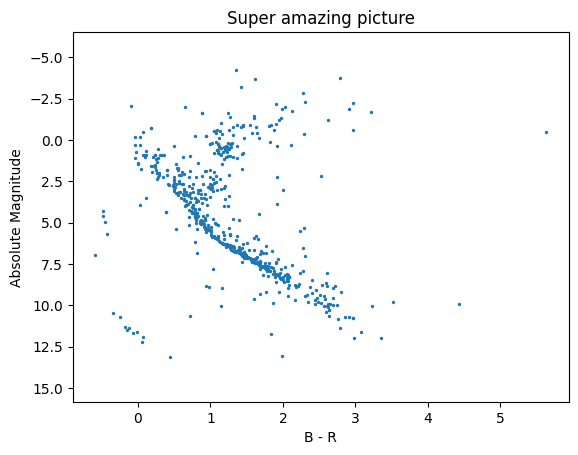

In [ ]:
x = data.bp_rp
#y = data.phot_g_mean_mag
y = data.phot_g_mean_mag - (5*np.log10(1000/data.parallax) - 5)
plt.scatter(x,y,s = 2)
plt.title('Super amazing picture')
plt.xlabel('B - R')
plt.ylabel('Absolute Magnitude')

ax = plt.gca()

# Calculate the 25% and 75% quantiles
y25 = np.nanquantile(y,.25)
y75 = np.nanquantile(y,.75)

# Calculate the interquantile range
IQR = y75 - y25

# Then (kinda) arbitrarily set the limits on the plot
myYMin = y25 - 1.5*IQR
myYMax = y75 + 1.5*IQR

ax.set_ylim([myYMin, myYMax])

ax.invert_yaxis()